In [13]:
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# Current dir 
current_dir = os.getcwd()
print( f"Directorio: { current_dir }" )
# Two levels above directory
parent_dir = os.path.abspath( os.path.join( current_dir, os.path.pardir, os.path.pardir ) )
print( f"Directorio padre: { parent_dir }" )
# Path to the data
directory = parent_dir + "/Datasets/20240215a_data/names/*.txt"

def findFiles( path ): return glob.glob( path )

print( findFiles( directory ))

Directorio: /home/xamanek/PythonProjects/ML_Transformers_001/MachineLearning/Classification
Directorio padre: /home/xamanek/PythonProjects/ML_Transformers_001
['/home/xamanek/PythonProjects/ML_Transformers_001/Datasets/20240215a_data/names/Czech.txt', '/home/xamanek/PythonProjects/ML_Transformers_001/Datasets/20240215a_data/names/Korean.txt', '/home/xamanek/PythonProjects/ML_Transformers_001/Datasets/20240215a_data/names/Chinese.txt', '/home/xamanek/PythonProjects/ML_Transformers_001/Datasets/20240215a_data/names/English.txt', '/home/xamanek/PythonProjects/ML_Transformers_001/Datasets/20240215a_data/names/Italian.txt', '/home/xamanek/PythonProjects/ML_Transformers_001/Datasets/20240215a_data/names/Portuguese.txt', '/home/xamanek/PythonProjects/ML_Transformers_001/Datasets/20240215a_data/names/German.txt', '/home/xamanek/PythonProjects/ML_Transformers_001/Datasets/20240215a_data/names/Japanese.txt', '/home/xamanek/PythonProjects/ML_Transformers_001/Datasets/20240215a_data/names/Vietname

In [9]:
# Turn a Unicode string to plain ASCII
def unicodeToAscii( s ):
  return ''.join(
    c for c in unicodedata.normalize('NFD', s)
    if unicodedata.category(c) != 'Mn'
    and c in all_letters # this last variable must not be a global variable and must be defined in the same scope as this function
  )

# Read a file and split into lines 
def readLines( filename ):
  lines = open( filename, encoding = 'utf-8' ).read().strip().split( '\n' )
  return [ unicodeToAscii( line ) for line in lines ]



In [10]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len( all_letters )

print( unicodeToAscii( 'Ślusàrski' ) )

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

for filename in findFiles( directory ):
  category = os.path.splitext( os.path.basename( filename ) )[0]
  all_categories.append( category )
  lines = readLines( filename )
  category_lines[ category ] = lines

n_categories = len( all_categories )

Slusarski


In [11]:
print( category_lines[ 'Italian' ][ :5 ] )

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [14]:
# Find letter index from all_letters, eg "a" = 0
def letterToIndex( letter ):
  return all_letters.find( letter )

# Just for demo, turn a letter into a <1 x n_letters> tensor
def letterToTensor( letter ):
  tensor = torch.zeros( 1, n_letters )
  tensor[ 0 ][ letterToIndex( letter ) ] = 1
  return tensor

# Turn a line into a <line_length x 1 x n_letters>, 
# or an array of one-hot letter vectors
def lineToTensor( line ):
  tensor = torch.zeros( len( line ), 1, n_letters )
  for li, letter in enumerate( line ):
    tensor[ li ][ 0 ][ letterToIndex( letter ) ] = 1
  return tensor

print( letterToTensor( 'J' ) )

print( lineToTensor( 'Jones' ).size() )

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [15]:
class RNN( nn.Module ):
  def __init__( self, input_size, hidden_size, output_size ):
    super( RNN, self ).__init__()

    self.hidden_size = hidden_size

    self.i2h = nn.Linear( input_size + hidden_size, hidden_size )
    self.h2o = nn.Linear( hidden_size, output_size )
    self.softmax = nn.LogSoftmax( dim = 1 )


  def forward( self, input, hidden ):
    combined = torch.cat( ( input, hidden ), 1 )
    hidden = self.i2h( combined )
    output = self.h2o( hidden )
    output = self.softmax( output )
    return output, hidden
  
  def initHidden( self ):
    return torch.zeros( 1, self.hidden_size )
  
n_hidden = 128
rnn = RNN( n_letters, n_hidden, n_categories )

In [16]:
input = letterToTensor( 'A' )
hidden = torch.zeros( 1, n_hidden )
output, next_hidden = rnn( input, hidden )

In [41]:
input = lineToTensor( 'Albert' )
hidden = torch.zeros( 1, n_hidden )

output, next_hidden = rnn( input[ 0 ], hidden )
print( output )

tensor([[-2.9699, -2.8840, -2.9289, -2.8141, -2.9308, -2.8864, -2.9592, -2.9137,
         -2.8650, -2.8599, -2.8308, -2.9014, -2.9313, -2.8881, -2.9007, -2.8587,
         -2.8936, -2.8265]], grad_fn=<LogSoftmaxBackward0>)


Prepare for Training

In [42]:
def categoryFromOutput( output ):
  top_n, top_i = output.topk( 1 )
  category_i = top_i[ 0 ].item()
  return all_categories[ category_i ], category_i

print( categoryFromOutput( output ) )

('English', 3)


In [44]:
def randomChoice( l ):
  return l[ random.randint( 0, len( l ) -1 ) ]

def randomTrainingExample():
  category = randomChoice( all_categories )
  line = randomChoice( category_lines[ category ] )
  category_tensor = torch.tensor( [ all_categories.index( category ) ], dtype = torch.long )
  line_tensor = lineToTensor( line )
  return category, line, category_tensor, line_tensor

for i in range( 10 ):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  print( 'category = ', category, '/ line = ', line )

category =  Portuguese / line =  Ventura
category =  Italian / line =  Rossini
category =  Scottish / line =  Macleod
category =  Dutch / line =  Vann
category =  Vietnamese / line =  Vuong
category =  Arabic / line =  Nader
category =  Russian / line =  Obolsky
category =  Chinese / line =  Sum
category =  Greek / line =  Vlahos
category =  Polish / line =  Szweda


In [45]:
criterion = nn.NLLLoss()

In [46]:
# If you set this too high, it might explode. If too low, it might not learn
learning_rate = 0.005

def train( category_tensor, line_tensor ):
  hidden = rnn.initHidden()

  rnn.zero_grad()

  for i in range( line_tensor.size()[0] ):
    output, hidden = rnn( line_tensor[ i ], hidden ) 
  
  loss = criterion( output, category_tensor )
  loss.backward()

  # Add parameters' gradients to their values, multiplied by learning rate
  for p in rnn.parameters():
    p.data.add_( p.grad.data, alpha = -learning_rate )

  return output, loss.item()

In [47]:
n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince( since ):
  now = time.time()
  s = now - since
  m = math.floor( s / 60 )
  s -= m * 60
  return '%dm %ds' % ( m, s )

start = time.time()

for iter in range( 1, n_iters + 1 ):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output, loss = train( category_tensor, line_tensor )
  current_loss += loss

  # Print ''iter'' number, loss, name and guess
  if iter % print_every == 0:
    guess, guess_i = categoryFromOutput( output )
    correct = '✓' if guess == category else '✗ (%s)' % category
    print( '%d %d%% (%s) %.4f %s / %s %s' % ( iter, iter / n_iters * 100, timeSince( start ), loss, line, guess, correct ) )

  # Add current loss avg to list of losses 
  if iter % plot_every == 0:
    all_losses.append( current_loss / plot_every )
    current_loss = 0


5000 5% (0m 3s) 2.5219 Chu / Vietnamese ✓
10000 10% (0m 6s) 1.5354 Vinh / Chinese ✗ (Vietnamese)
15000 15% (0m 10s) 1.6776 Cabrera / Portuguese ✗ (Spanish)
20000 20% (0m 13s) 2.5132 Ngai / Chinese ✗ (Korean)
25000 25% (0m 16s) 2.3526 Worrall / Scottish ✗ (English)
30000 30% (0m 20s) 1.3042 Zhuo / Vietnamese ✗ (Chinese)
35000 35% (0m 23s) 1.8639 Hoyle / Irish ✗ (English)
40000 40% (0m 26s) 0.8991 Santos / Portuguese ✓
45000 45% (0m 30s) 0.3197 Bonnaire / French ✓
50000 50% (0m 33s) 1.7826 Colman / English ✓
55000 55% (0m 36s) 2.8827 Leeuwenhoek / Polish ✗ (Dutch)
60000 60% (0m 40s) 1.1458 Nigro / Portuguese ✗ (Italian)
65000 65% (0m 43s) 0.5037 Aswad / Arabic ✓
70000 70% (0m 46s) 1.0310 Chu / Vietnamese ✓
75000 75% (0m 50s) 2.3927 De la fontaine / Portuguese ✗ (French)
80000 80% (0m 53s) 1.7760 Djigit / French ✗ (Russian)
85000 85% (0m 57s) 1.3173 Pellegrino / Spanish ✗ (Italian)
90000 90% (1m 0s) 0.0765 Kozlowski / Polish ✓
95000 95% (1m 4s) 0.0948 Kyritsis / Greek ✓
100000 100% (1m 7s

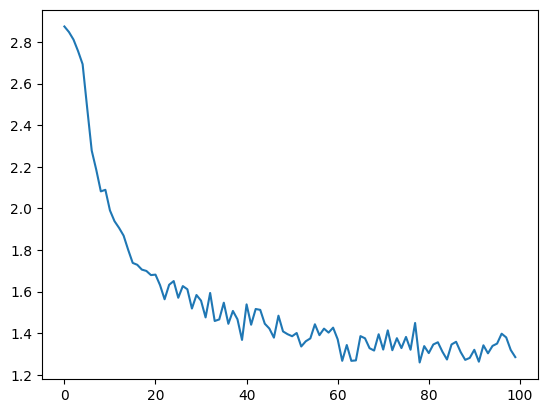

In [48]:
plt.figure()
plt.plot( all_losses )

/tmp/ipykernel_21836/3736229918.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels( [''] + all_categories, rotation = 90 )
/tmp/ipykernel_21836/3736229918.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels( [''] + all_categories )


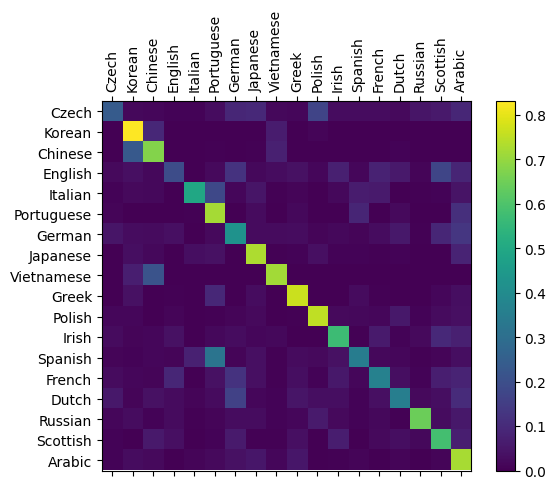

In [49]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros( n_categories, n_categories )
n_confusion = 10000

# Just return an output given a line
def evaluate( line_tensor ):
  hidden = rnn.initHidden()

  for i in range( line_tensor.size()[0] ):
    output, hidden = rnn( line_tensor[i], hidden )

  return output

# Go through a bunch of examples and record which are correctly guessed
for i in range( n_confusion ):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output = evaluate( line_tensor )
  guess, guess_i = categoryFromOutput( output )
  category_i = all_categories.index( category )
  confusion[ category_i ][ guess_i ] += 1

# Normalize by dividing every row by its sum
for i in range( n_categories ):
  confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot( 111 )
cax = ax.matshow( confusion.numpy() )
fig.colorbar( cax )

# Set up axes
ax.set_xticklabels( [''] + all_categories, rotation = 90 )
ax.set_yticklabels( [''] + all_categories )

# Force label at every tick
ax.xaxis.set_major_locator( ticker.MultipleLocator( 1 ) )
ax.yaxis.set_major_locator( ticker.MultipleLocator( 1 ) )

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [51]:
def predict( input_line, n_predictions = 3 ):
  print( '\n> %s' % input_line )
  with torch.no_grad():
    output = evaluate( lineToTensor( input_line ) )

    # Get top N categories
    topv, topi = output.topk( n_predictions, 1, True )
    predictions = []

    for i in range( n_predictions ):
      value = topv[0][i].item()
      category_index = topi[0][i].item()
      print( '(%.2f) %s' % ( value, all_categories[category_index] ) )
      predictions.append( [ value, all_categories[ category_index ] ] )

predict( 'Dovesky' )
predict( 'Jackson' )
predict( 'Satoshi' )
predict( 'Pablo' )
predict( 'Luis' )
predict( 'Xamanek' )


> Dovesky
(-0.43) Russian
(-1.41) Czech
(-2.55) Polish

> Jackson
(-0.29) Scottish
(-1.82) English
(-3.75) French

> Satoshi
(-0.73) Japanese
(-0.88) Arabic
(-2.55) Italian

> Pablo
(-0.95) Portuguese
(-1.10) Spanish
(-1.52) Italian

> Luis
(-1.19) Portuguese
(-1.26) Arabic
(-1.80) Greek

> Xamanek
(-0.50) Polish
(-1.99) Czech
(-2.30) Dutch
